# Handle extreme outliers in day-ahead-auction-price

## ❌ IQR method
This method works at global level, does not take evolution in time. It detects global outliers that are not really outiers in a local context

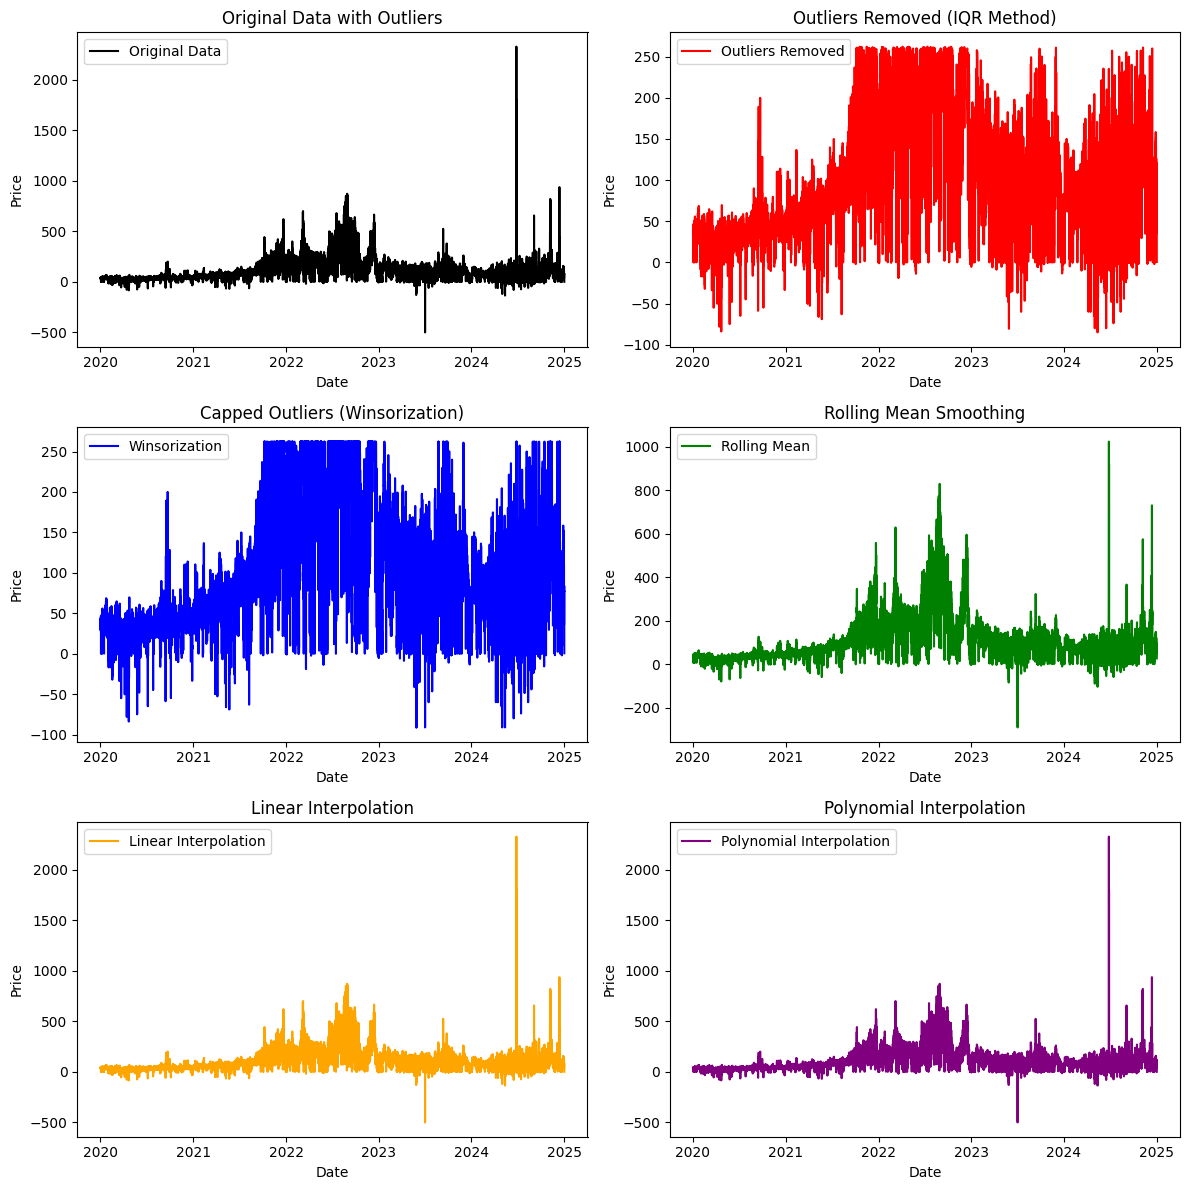

In [10]:
# Load the dataset
file_path = "../data/ml-engineer-dataset.csv"
df_real = pd.read_csv(file_path, parse_dates=["contract-delivery"])

# Ensure it's sorted by time
df_real = df_real.sort_values("contract-delivery")

# Extract relevant columns
price_col = "day-ahead-auction-price"  # Adjust if column name differs
df_real = df_real[["contract-delivery", price_col]].dropna()

# Compute IQR for outlier detection
Q1_real = df_real[price_col].quantile(0.25)
Q3_real = df_real[price_col].quantile(0.75)
IQR_real = Q3_real - Q1_real
lower_bound_real = Q1_real - 1.5 * IQR_real
upper_bound_real = Q3_real + 1.5 * IQR_real

# 1. Remove Outliers (IQR Method)
df_removed_real = df_real[(df_real[price_col] >= lower_bound_real) & (df_real[price_col] <= upper_bound_real)]

# 2. Cap Outliers (Winsorization)
df_capped_real = df_real.copy()
df_capped_real[price_col] = np.where(df_real[price_col] > upper_bound_real, upper_bound_real, 
                                     np.where(df_real[price_col] < lower_bound_real, lower_bound_real, df_real[price_col]))

# 3. Rolling Mean Smoothing
df_smoothed_real = df_real.copy()
df_smoothed_real[price_col] = df_smoothed_real[price_col].rolling(window=5, center=True).mean()

# 4. Interpolation (Linear & Polynomial)
df_interp_real = df_real.copy()
df_interp_real["price_linear"] = df_interp_real[price_col].interpolate(method="linear")
df_interp_real["price_poly"] = df_interp_real[price_col].interpolate(method="polynomial", order=3)

# Plot all methods
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

# Original Data
axs[0].plot(df_real["contract-delivery"], df_real[price_col], label="Original Data", color="black")
axs[0].set_title("Original Data with Outliers")

# Remove Outliers
axs[1].plot(df_removed_real["contract-delivery"], df_removed_real[price_col], label="Outliers Removed", color="red")
axs[1].set_title("Outliers Removed (IQR Method)")

# Capped Outliers
axs[2].plot(df_capped_real["contract-delivery"], df_capped_real[price_col], label="Winsorization", color="blue")
axs[2].set_title("Capped Outliers (Winsorization)")

# Rolling Mean Smoothing
axs[3].plot(df_smoothed_real["contract-delivery"], df_smoothed_real[price_col], label="Rolling Mean", color="green")
axs[3].set_title("Rolling Mean Smoothing")

# Interpolation - Linear
axs[4].plot(df_interp_real["contract-delivery"], df_interp_real["price_linear"], label="Linear Interpolation", color="orange")
axs[4].set_title("Linear Interpolation")

# Interpolation - Polynomial
axs[5].plot(df_interp_real["contract-delivery"], df_interp_real["price_poly"], label="Polynomial Interpolation", color="purple")
axs[5].set_title("Polynomial Interpolation")

for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()


## ✅ Local Window Methods for Outliers
- We need to detect **outliers in local windows** and
- **smooth ONLY outlier points**. Do not smooth points that are not outliers.
- Tried diffrent methods:
    - 👍rolling median: (With a large window and high threshold for outlier detection) is capable of smoothing local outliers
    - rolling_mean_clipping: Not working fine
    - locf (Last Observation Carried Forward): Not working fine
    - Savitzky-Golay Filter: smoothes all samples. Not wanted

In [79]:
# Load dataset (replace with actual dataset)
df_orig = pd.read_csv("../data/ml-engineer-dataset.csv")
cols = list(df_orig.columns)
cols

['contract-delivery',
 'demand-forecast',
 'temperature-normal',
 'temperature-forecast',
 'solar-forecast',
 'day-ahead-auction-price',
 'wind-forecast',
 'day-ahead-auction-time']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load dataset (replace with actual dataset)
df = pd.read_csv("../data/ml-engineer-dataset.csv")
df['contract-delivery'] = pd.to_datetime(df['contract-delivery'])  # Ensure contract-delivery is datetime

# Detect outliers (Z-score method as a reference)
def detect_outliers_zscore(series, threshold=6):
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    return abs(z_scores) > threshold

outliers = detect_outliers_zscore(df['day-ahead-auction-price'])

# Method 1: Rolling Median Smoothing
def rolling_median_smoothing(series, window=200):
    return series.where(~outliers, series.rolling(window, center=True).median())

df['rolling_median'] = rolling_median_smoothing(df['day-ahead-auction-price'])

# Method 2: Rolling Mean with Clipping
def rolling_mean_clipping(series, window=5, std_factor=2):
    rolling_mean = series.rolling(window, center=True).mean()
    rolling_std = series.rolling(window, center=True).std()
    lower_bound, upper_bound = rolling_mean - std_factor * rolling_std, rolling_mean + std_factor * rolling_std
    return np.clip(series, lower_bound, upper_bound)

df['rolling_mean_clip'] = rolling_mean_clipping(df['day-ahead-auction-price'])

# Method 3: LOCF (Last Observation Carried Forward)
def locf(series):
    return series.where(~outliers, series.ffill().bfill())

df['locf'] = locf(df['day-ahead-auction-price'])

# Method 4: Savitzky-Golay Filter
def savgol_smoothing(series, window=11, poly=2):
    return savgol_filter(series, window_length=window, polyorder=poly, mode='nearest')

df['savgol'] = savgol_smoothing(df['day-ahead-auction-price'])


In [3]:
len(outliers[outliers==True])

47

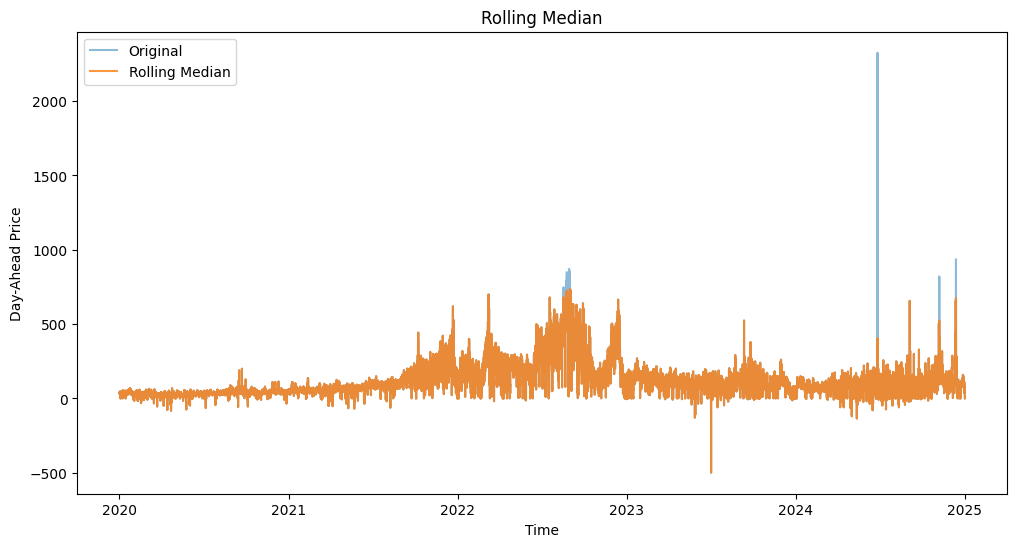

In [4]:
# Plot comparisons
plt.figure(figsize=(12, 6))
plt.plot(df['contract-delivery'], df['day-ahead-auction-price'], label='Original', alpha=0.5)
plt.plot(df['contract-delivery'], df['rolling_median'], label='Rolling Median', alpha=0.8)
plt.legend()
plt.title("Rolling Median")
plt.xlabel("Time")
plt.ylabel("Day-Ahead Price")
plt.show()

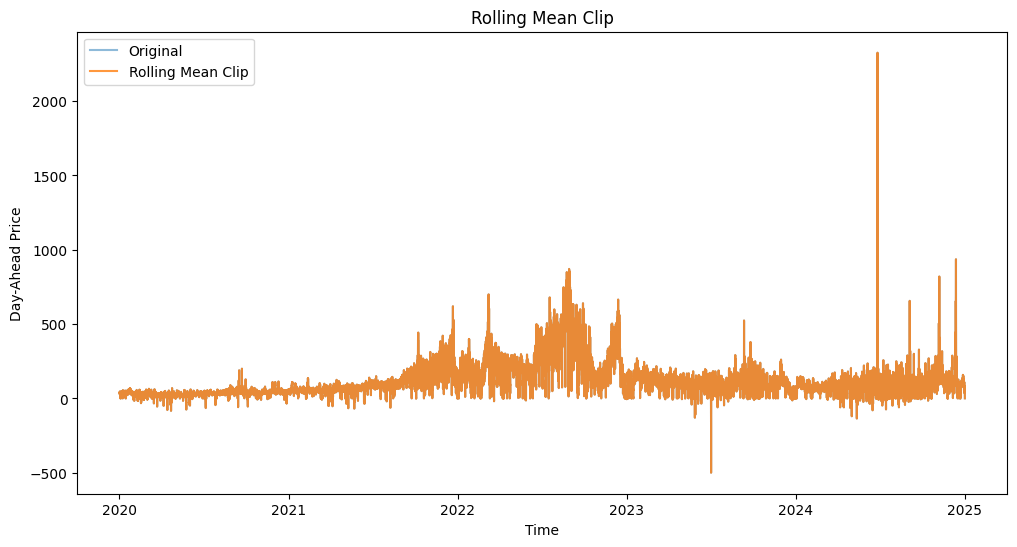

In [7]:
# Plot comparisons
plt.figure(figsize=(12, 6))
plt.plot(df['contract-delivery'], df['day-ahead-auction-price'], label='Original', alpha=0.5)
plt.plot(df['contract-delivery'], df['rolling_mean_clip'], label='Rolling Mean Clip', alpha=0.8)
plt.legend()
plt.title("Rolling Mean Clip")
plt.xlabel("Time")
plt.ylabel("Day-Ahead Price")
plt.show()

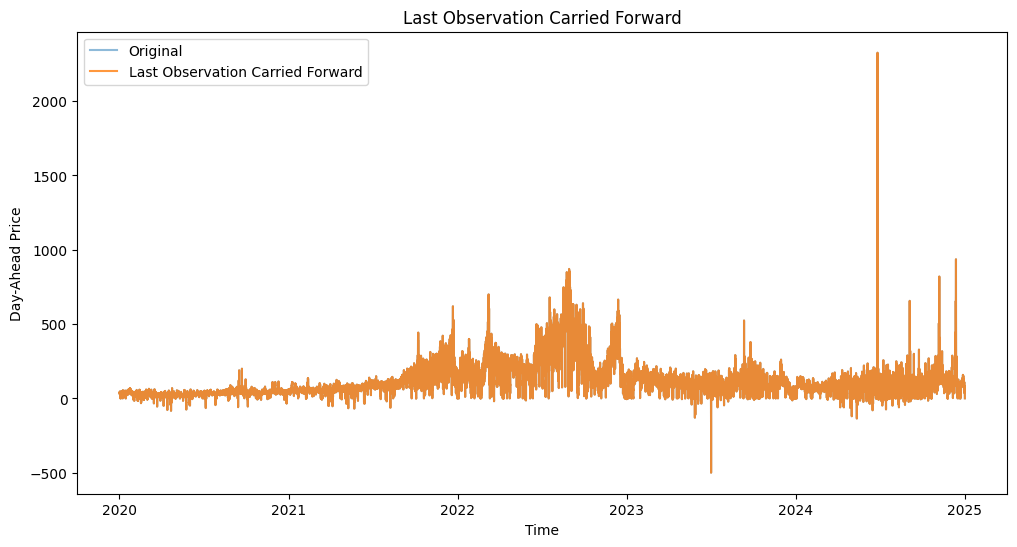

In [8]:
# Plot comparisons
plt.figure(figsize=(12, 6))
plt.plot(df['contract-delivery'], df['day-ahead-auction-price'], label='Original', alpha=0.5)
plt.plot(df['contract-delivery'], df['locf'], label='Last Observation Carried Forward', alpha=0.8)
plt.legend()
plt.title("Last Observation Carried Forward")
plt.xlabel("Time")
plt.ylabel("Day-Ahead Price")
plt.show()

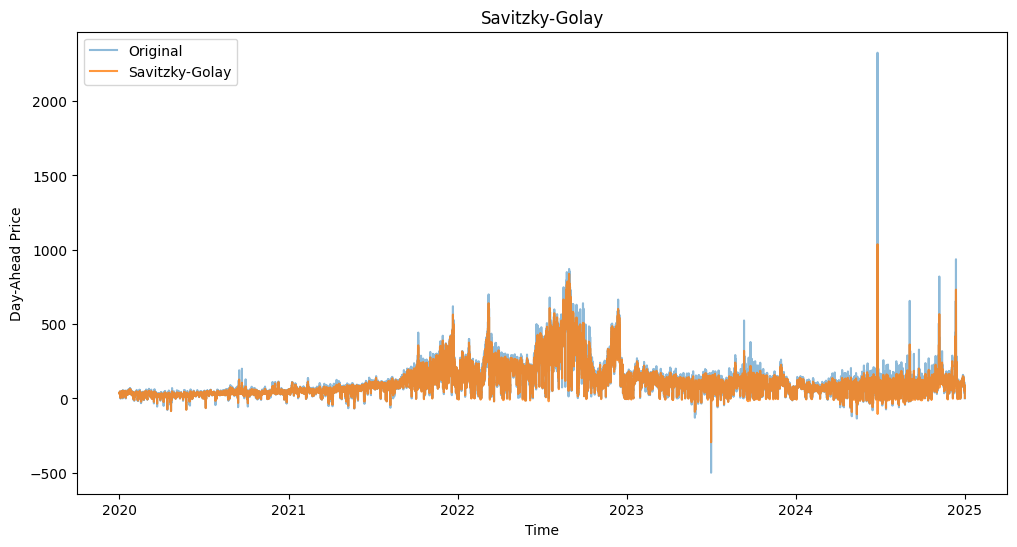

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(df['contract-delivery'], df['day-ahead-auction-price'], label='Original', alpha=0.5)
plt.plot(df['contract-delivery'], df['savgol'], label='Savitzky-Golay', alpha=0.8)
plt.legend()
plt.title("Savitzky-Golay")
plt.xlabel("Time")
plt.ylabel("Day-Ahead Price")
plt.show()

## Save Dataset with rolling-median smoothing of outliers

In [77]:
df[cols + ['rolling_median']]

,contract-delivery,demand-forecast,temperature-normal,temperature-forecast,solar-forecast,day-ahead-auction-price,wind-forecast,day-ahead-auction-time,rolling_median
0,2020-01-01 00:00:00+00:00,43471.50,1.317628,0.6,0.0,38.60,7019.50,2019-12-31 11:00:00+00:00,38.60
1,2020-01-01 01:00:00+00:00,42555.50,1.285980,0.3,0.0,36.55,7407.00,2019-12-31 11:00:00+00:00,36.55
2,2020-01-01 02:00:00+00:00,42448.25,1.224420,-0.1,0.0,32.32,7540.50,2019-12-31 11:00:00+00:00,32.32
3,2020-01-01 03:00:00+00:00,42567.75,1.169376,-0.4,0.0,30.85,7802.75,2019-12-31 11:00:00+00:00,30.85
4,2020-01-01 04:00:00+00:00,42209.00,1.101194,-0.7,0.0,30.14,7805.75,2019-12-31 11:00:00+00:00,30.14
...,...,...,...,...,...,...,...,...,...
43842,2024-12-31 18:00:00+00:00,56083.25,2.059095,0.9,0.0,67.77,32407.00,2024-12-30 11:00:00+00:00,67.77
43843,2024-12-31 19:00:00+00:00,53423.00,1.876822,0.9,0.0,35.56,33725.00,2024-12-30 11:00:00+00:00,35.56
43844,2024-12-31 20:00:00+00:00,50937.50,1.730909,1.1,0.0,15.70,34342.00,2024-12-30 11:00:00+00:00,15.70
43845,2024-12-31 21:00:00+00:00,47657.50,1.620814,1.3,0.0,9.06,33834.25,2024-12-30 11:00:00+00:00,9.06


In [78]:
df['day-ahead-auction-price']=df['rolling_median']

In [80]:
df=df[cols]

In [82]:
df.to_csv("../data/ml-engineer-dataset-smoothed_outliers.csv")